In [18]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math

measles_data = genfromtxt('measles.csv', delimiter=',') #in the form of [t, S, E, I]

torch.manual_seed(1234)

In [19]:
%%time

PATH = 'measles' 

class DINN(nn.Module):
    def __init__(self, t, S_data, E_data, I_data):
        super(DINN, self).__init__()
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 
        self.S = torch.tensor(S_data)
        self.E = torch.tensor(E_data)
        self.I = torch.tensor(I_data)
        self.N = torch.tensor(50001) #self.S + self.E + self.I

        self.losses = [] #keep the losses
        self.save = 2 #which file to save to

        #learnable parameters
        
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.02) 
        self.beta0_tilda = torch.tensor(0.0010107 * self.N)
        self.beta1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.28)
        self.gamma_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(100)
        self.sigma_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(35.84)

        #matrices (x3 for S, E, I) for the gradients
        self.m1 = torch.zeros((len(self.t), 3)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 3)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 3)); self.m3[:, 2] = 1

        #values for norm
        self.S_max = max(self.S)
        self.E_max = max(self.E)
        self.I_max = max(self.I)
        self.S_min = min(self.S)
        self.E_min = min(self.E)
        self.I_min = min(self.I)
        
        #normalize 
        self.S_hat = (self.S - self.S_min)/(self.S_max - self.S_min)
        self.E_hat = (self.E - self.E_min)/(self.E_max - self.E_min)
        self.I_hat = (self.I - self.I_min)/(self.I_max - self.I_min)

        #NN
        self.net_measles = self.Net_measles()
        self.params = list(self.net_measles.parameters())
        self.params.extend(list([self.mu_tilda, self.beta0_tilda, self.beta1_tilda, self.gamma_tilda, self.sigma_tilda]))

        
    #force parameters to be in a range
    @property 
    def mu(self):
        return torch.tanh(self.mu_tilda ) * 0.01 + 0.02

    @property 
    def beta0(self):
        return self.beta0_tilda 

    @property 
    def beta1(self):
        return torch.tanh(self.beta1_tilda ) * 0.05 + 0.32

    @property 
    def gamma(self):
        return torch.tanh(self.gamma_tilda ) * 3 + 100 #* 10 + 100 

    @property 
    def sigma(self):
        return torch.tanh(self.sigma_tilda ) * 2 + 35 #* 5 + 35 

    #nets
    class Net_measles(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.Net_measles, self).__init__()
            self.fc1=nn.Linear(1, 64) #takes 100 t's
            self.fc2=nn.Linear(64, 64)
            self.fc3=nn.Linear(64, 64)
            self.fc4=nn.Linear(64, 64)
            self.fc5=nn.Linear(64, 64)
            self.fc6=nn.Linear(64, 64)
            self.fc7=nn.Linear(64, 64)
            self.fc8=nn.Linear(64, 64)
            self.out=nn.Linear(64, 3) #outputs S, E, I

        def forward(self, t):
            measles=F.relu(self.fc1(t))
            measles=F.relu(self.fc2(measles))
            measles=F.relu(self.fc3(measles))
            measles=F.relu(self.fc4(measles))
            measles=F.relu(self.fc5(measles))
            measles=F.relu(self.fc6(measles))
            measles=F.relu(self.fc7(measles))
            measles=F.relu(self.fc8(measles))
            measles=self.out(measles)
            return measles    

    def net_f(self, t_batch):       

        measles_hat = self.net_measles(t_batch)

        S_hat, E_hat, I_hat = measles_hat[:,0], measles_hat[:,1], measles_hat[:,2]

        #S_hat
        measles_hat.backward(self.m1, retain_graph=True)
        S_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #E_hat
        measles_hat.backward(self.m2, retain_graph=True)
        E_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_hat
        measles_hat.backward(self.m3, retain_graph=True)
        I_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #unnormalize
        S = self.S_min + (self.S_max - self.S_min) * S_hat
        E = self.E_min + (self.E_max - self.E_min) * E_hat
        I = self.I_min + (self.I_max - self.I_min) * I_hat
     
        #equations
        beta = self.beta0 * (1 + self.beta1 * torch.cos(2 * torch.tensor(math.pi) * self.t_batch))

        f1_hat = S_hat_t - (self.mu * (self.N - self.S) - (beta * self.S * self.I)/self.N) / (self.S_max - self.S_min) 
        f2_hat = E_hat_t - ((beta * self.S * self.I)/self.N - (self.mu * self.sigma) * self.E) / (self.E_max - self.E_min) 
        f3_hat = I_hat_t - (self.sigma * self.E - (self.mu + self.gamma) * self.I) / (self.I_max - self.I_min) 

        return f1_hat, f2_hat, f3_hat, S_hat, E_hat, I_hat
    
    def load(self):
      # Load checkpoint
      try:
        checkpoint = torch.load(PATH + str(self.save)+'.pt') 
        print('\nloading pre-trained model...')
        self.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        self.losses = checkpoint['losses']
        print('loaded previous loss: ', loss)
      except RuntimeError :
          print('changed the architecture, ignore')
          pass
      except FileNotFoundError:
          pass

    def train(self, n_epochs):
      #try loading
      self.load()

      #train
      print('\nstarting training...\n')
      
      for epoch in range(n_epochs):
        #lists to hold the output (maintain only the final epoch)
        S_pred_list = []
        E_pred_list = []
        I_pred_list = []

        f1_hat, f2_hat, f3_hat, S_hat_pred, E_hat_pred, I_hat_pred = self.net_f(self.t_batch)
        self.optimizer.zero_grad()

        S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_hat_pred)
        E_pred_list.append(self.E_min + (self.E_max - self.E_min) * E_hat_pred)
        I_pred_list.append(self.I_min + (self.I_max - self.I_min) * I_hat_pred)

        loss = (
              torch.mean(torch.square(self.S_hat - S_hat_pred)) + torch.mean(torch.square(self.E_hat - E_hat_pred)) + 
              torch.mean(torch.square(self.I_hat - I_hat_pred)) +
              torch.mean(torch.square(f1_hat)) + torch.mean(torch.square(f2_hat)) +
              torch.mean(torch.square(f3_hat))
               )

        loss.backward()

        self.optimizer.step()
        self.scheduler.step() 
        #self.scheduler.step(loss) 

        self.losses.append(loss.item())

        if epoch % 1000 == 0:          
          print('\nEpoch ', epoch)

        #loss + model parameters update
        if epoch % 4000 == 0:
          #checkpoint save every 1000 epochs if the loss is lower
          print('\nSaving model... Loss is: ', loss)
          torch.save({
              'epoch': epoch,
              'model': self.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'scheduler': self.scheduler.state_dict(),
              'loss': loss,
              'losses': self.losses,
              }, PATH + str(self.save)+'.pt')
          if self.save % 2 > 0: #its on 3
            self.save = 2 #change to 2
          else: #its on 2
            self.save = 3 #change to 3

          print('epoch: ', epoch)
          print('#################################')
        
      #plot
      plt.plot(self.losses, color = 'teal')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      return S_pred_list, E_pred_list, I_pred_list

CPU times: user 58 µs, sys: 0 ns, total: 58 µs
Wall time: 62.7 µs


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



loading pre-trained model...
loaded previous loss:  tensor(0.2082, dtype=torch.float64, requires_grad=True)

starting training...


Epoch  0

Saving model... Loss is:  tensor(0.2082, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch:  0
mu: (goal 0.02) tensor([0.0225], grad_fn=<AddBackward0>)

beta1: (goal 0.28 ):  tensor([0.2700], grad_fn=<AddBackward0>)

gamma (goal 100):  tensor([97.0001], grad_fn=<AddBackward0>)

sigma: (goal 35.84):  tensor([34.7127], grad_fn=<AddBackward0>)
#################################

Epoch  1000

Epoch  2000

Epoch  3000

Epoch  4000

Saving model... Loss is:  tensor(0.2094, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  4000
mu: (goal 0.02) tensor([0.0225], grad_fn=<AddBackward0>)

beta1: (goal 0.28 ):  tensor([0.2700], grad_fn=<AddBackward0>)

gamma (goal 100):  tensor([97.0001], grad_fn=<AddBackward0>)

sigma: (goal 35.84):  tensor([34.7127], grad_fn=<AddBackward0>)
#################################

Epoch  5000

Epoch  6000

Epoch  7000

Epoch  8000

Saving model... Loss is:  tensor(0.2094, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  8000
mu: (goal 0.02) tensor([0.0225], grad_fn=<AddBackward0>)

beta1: (goal 0.28 ):  tensor([0.2700], grad_fn=<AddBackward0>)



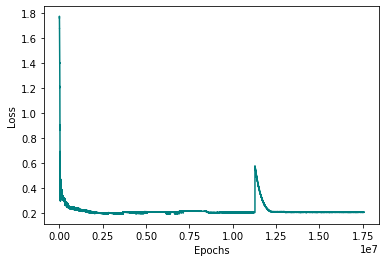

In [20]:
%%time

#this worked best
dinn = DINN(measles_data[0], measles_data[1], measles_data[2], measles_data[3])

learning_rate = 1e-3
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(dinn.optimizer, factor=0.85, patience = 5000, verbose=True, min_lr=1e-7)
#scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-6, max_lr=1e-3, step_size_up=1000, mode="triangular2", cycle_momentum=False)
scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-7, max_lr=1e-3, step_size_up=1000, mode="exp_range", gamma=0.85, cycle_momentum=False)

dinn.scheduler = scheduler

try: 
  S_pred_list, E_pred_list, I_pred_list = dinn.train(10000) #train
except EOFError:
  if dinn.save == 2:
    dinn.save = 3
    S_pred_list, E_pred_list, I_pred_list = dinn.train(10000) #train
  elif dinn.save == 3:
    dinn.save = 2
    S_pred_list, E_pred_list, I_pred_list = dinn.train(10000) #train

Text(0, 0.5, 'Loss')

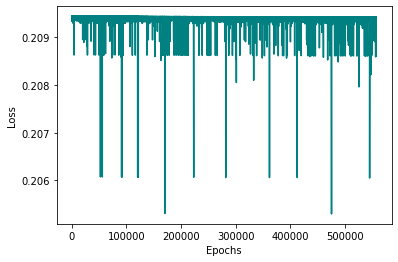

In [28]:
plt.plot(dinn.losses[17000000:], color = 'teal')
plt.xlabel('Epochs')
plt.ylabel('Loss')

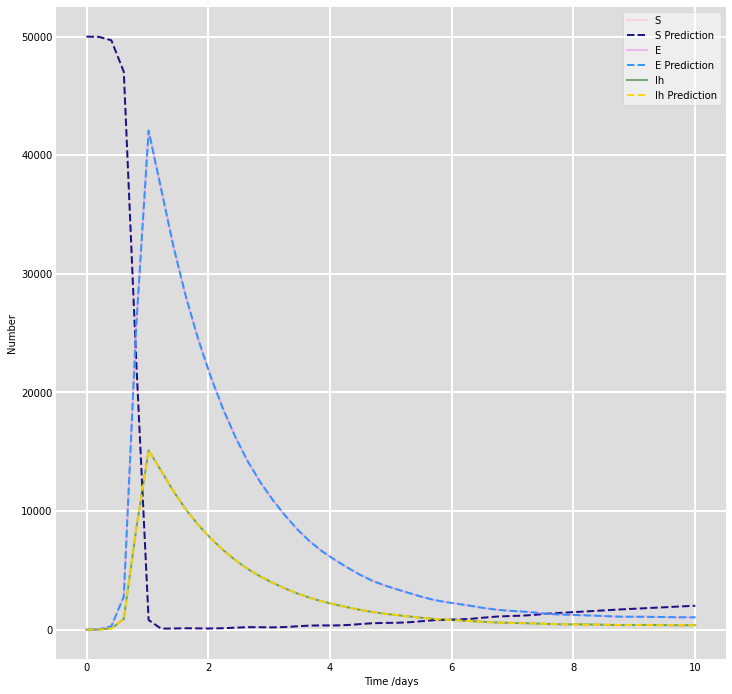

In [22]:
fig = plt.figure(facecolor='w', figsize=(12,12))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

ax.plot(measles_data[0], measles_data[1], 'pink', alpha=0.5, lw=2, label='S')
ax.plot(measles_data[0], S_pred_list[0].detach().numpy(), 'navy', alpha=0.9, lw=2, label='S Prediction', linestyle='dashed')

ax.plot(measles_data[0], measles_data[2], 'violet', alpha=0.5, lw=2, label='E')
ax.plot(measles_data[0], E_pred_list[0].detach().numpy(), 'dodgerblue', alpha=0.9, lw=2, label='E Prediction', linestyle='dashed')

ax.plot(measles_data[0], measles_data[3], 'darkgreen', alpha=0.5, lw=2, label='Ih')
ax.plot(measles_data[0], I_pred_list[0].detach().numpy(), 'gold', alpha=0.9, lw=2, label='Ih Prediction', linestyle='dashed')


ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
#ax.set_ylim([-1,50])
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [23]:
# -print('alpha1: (goal 1)', round(dinn.alpha1.item(),2))
# print('\nalpha2: (goal 0)', round(dinn.alpha2.item(),2))
# print('\nbeta: (goal 0.0075): ', round(dinn.beta.item(),4))
# print('\nmu (goal 5): ', round(dinn.mu.item(),2))
# print('\nu: (goal 0.515151515): ', round(dinn.u.item(),2))
# print('\ntao (goal 0.58): ', round(dinn.tao.item(),2))


# print('\nerror:')
# print('alpha1: ', round((1-round(dinn.alpha1.item(),2))/1,2)*100,'%')
# print('alpha2: ', round((0-round(dinn.alpha2.item(),2))/1e-20,2)*100,'%')
# print('beta: ', round((0.0075-round(dinn.beta.item(),4))/0.0075,2)*100,'%')
# print('mu: ', round((5-round(dinn.mu.item(),2))/5,2)*100,'%')
# print('u: ', round((0.515151515-round(dinn.u.item(),2))/0.515151515,2)*100,'%')
# print('tao: ', round((0.58-round(dinn.tao.item(),2))/0.58,2)*100,'%')

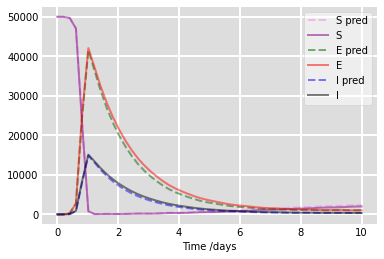

In [24]:
#vaccination! 

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Initial conditions
S0 = 5e4
E0 = 0
I0 = 1
N = S0 + E0 + I0

# A grid of time points (in days)
t = np.linspace(0, 10, 50) 

#parameters
mu = dinn.mu
beta0 = 0.0010107 * N
beta1 = dinn.beta1
gamma = dinn.gamma
sigma = dinn.sigma

# The SIR model differential equations.
def deriv(y, t, N, mu, beta0, beta1, gamma, sigma):
    S, E, I = y
    beta = beta0 * (1 + beta1 * np.cos(2 * np.pi * t))

    dSdt = mu * (N - S) - (beta * S * I)/N
    dEdt = (beta * S * I)/N - (mu * sigma) * E
    dIdt = sigma * E - (mu + gamma) * I

    return dSdt, dEdt, dIdt


# Initial conditions vector
y0 = S0, E0, I0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, mu, beta0, beta1, gamma, sigma))
S, E, I = ret.T

# Plot the data on two separate curves for S(t), I(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S, 'violet', alpha=0.5, lw=2, label='S pred', linestyle='dashed')
ax.plot(measles_data[0], measles_data[1], 'purple', alpha=0.5, lw=2, label='S')

ax.plot(t, E, 'darkgreen', alpha=0.5, lw=2, label='E pred', linestyle='dashed')
ax.plot(measles_data[0], measles_data[2], 'red', alpha=0.5, lw=2, label='E')

ax.plot(t, I, 'blue', alpha=0.5, lw=2, label='I pred', linestyle='dashed')
ax.plot(measles_data[0], measles_data[3], 'black', alpha=0.5, lw=2, label='I')


ax.set_xlabel('Time /days')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [25]:
#calculate relative MSE loss
import math

S_total_loss = 0
S_den = 0
I_total_loss = 0
I_den = 0
E_total_loss = 0
E_den = 0
for timestep in range(len(t)):
  S_value = measles_data[1][timestep] - S[timestep]
  S_total_loss += S_value**2
  S_den += (measles_data[1][timestep])**2

  E_value = measles_data[2][timestep] - E[timestep]
  E_total_loss += E_value**2
  E_den += (measles_data[2][timestep])**2
  
  I_value = measles_data[3][timestep] - I[timestep]
  I_total_loss += I_value**2
  I_den += (measles_data[3][timestep])**2

S_total_loss = math.sqrt(S_total_loss/S_den)
I_total_loss = math.sqrt(I_total_loss/I_den)
E_total_loss = math.sqrt(E_total_loss/E_den)
print('S_total_loss: ', S_total_loss)
print('E_total_loss: ', E_total_loss)
print('I_total_loss: ', I_total_loss)

S_total_loss:  0.017504710259372978
E_total_loss:  0.0584883409697206
I_total_loss:  0.059577861286207075
